###  **Macroeconomia vs. E-commerce**
---

Fundamentos Macroeconômicos: Construindo a Base para Análise de E-commerce (2016-2018)

- Expectativas de Mercado **(Focus)**
Fornece as projeções de instituições financeiras para indicadores como **IPCA esperado**. Útil para análise de sentimentos do mercado.

Acesso: Portal de Dados Abertos BCB

- Sistema Gerenciador de Séries Temporais **(SGS)**
Repositório oficial para dados históricos e realizados (**IPCA real**, **Selic efetiva**, etc.). Fundamental para validação estatística.

Acesso: Interface de Consulta SGS

In [1]:
# ajusta path para importar utilidades do projeto
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))

In [2]:
# importa bibliotecas EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from bcb import sgs, Expectativas
from sklearn.preprocessing import StandardScaler
from utils.viz_config import PALETA_OLIST

In [7]:
# formata o pandas para mostrar apenas 2 casas decimais
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [8]:
# função principal para coleta dos dados pelos APIs
def coletar_dados_macro_mensal():
    """
    Obtém indicadores macroeconômicos do Banco Central do Brasil (BCB).

    Processo:
    1. Consome Selic e IPCA acumulado de 12m via API do SGS.
    2. Consome expectativas de inflação de 12m via API do Focus.
    3. Calcula a Taxa de Juros Real (Esperada e Efetiva) via Equação de Fisher.
    4. Agrupa os dados por média mensal (Resample 'MS').

    Returns:
        pd.DataFrame: Dados mensais com juros nominais, inflação e juro real.
    """
    data_inicio = "2016-01-01"
    data_fim = "2018-12-31"

    # 1. Coleta Selic e IPCA (SGS)
    selic = sgs.get({"juros_base_selic": 432}, start=data_inicio, end=data_fim)
    ipca_12m = sgs.get(
        {"inflacao_realizada_12m": 13522}, start=data_inicio, end=data_fim
    )

    # 2. Expectativa Focus
    service = Expectativas()
    exp_12m = service.get_endpoint("ExpectativasMercadoInflacao12Meses")
    df_focus = (
        exp_12m.query()
        .filter(
            exp_12m.Indicador == "IPCA",
            exp_12m.Data >= data_inicio,
            exp_12m.Data <= data_fim,
        )
        .select(exp_12m.Data, exp_12m.Media)
        .collect()
    )

    # Prepara Focus: garante que a data é datetime e define como índice
    df_focus["Data"] = pd.to_datetime(df_focus["Data"])
    ipca_exp = (
        df_focus.groupby("Data")["Media"].mean().to_frame("previsao_inflacao_12m")
    )

    # 3. Join dos dados diários e preenchimento
    df_macro = selic.join([ipca_exp, ipca_12m]).ffill()

    # 4. RESAMPLE: Agrupamento Mensal pela Média
    # 'MS' define o índice como o primeiro dia do mês (Month Start)
    df_mensal = df_macro.resample("MS").mean()

    # 5. Cálculo das Taxas Reais (sobre os dados já mensais)
    # Aplicando a Equação de Fisher
    df_mensal["custo_real_esperado"] = (
        (
            (1 + df_mensal["juros_base_selic"] / 100)
            / (1 + df_mensal["previsao_inflacao_12m"] / 100)
        )
        - 1
    ) * 100
    df_mensal["custo_real_efetivo"] = (
        (
            (1 + df_mensal["juros_base_selic"] / 100)
            / (1 + df_mensal["inflacao_realizada_12m"] / 100)
        )
        - 1
    ) * 100

    return df_mensal.dropna()

In [9]:
# Executar coleta
df_final = coletar_dados_macro_mensal()

In [10]:
# df_final.to_csv('back_up_coleta_api_bcb.csv')
print(f"O Back Up da coleta realizado com sucesso.")

O Back Up da coleta realizado com sucesso.


In [11]:
df_final.head()

,juros_base_selic,previsao_inflacao_12m,inflacao_realizada_12m,custo_real_esperado,custo_real_efetivo
Date,,,,,
2016-01-01,14.25,7.05,10.71,6.72,3.20
2016-02-01,14.25,6.97,10.36,6.80,3.52
2016-03-01,14.25,6.66,9.39,7.12,4.44
2016-04-01,14.25,6.33,9.28,7.45,4.55
2016-05-01,14.25,6.08,9.32,7.70,4.51


In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2016-01-01 to 2018-12-01
Freq: MS
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   juros_base_selic        36 non-null     float64
 1   previsao_inflacao_12m   36 non-null     float64
 2   inflacao_realizada_12m  36 non-null     float64
 3   custo_real_esperado     36 non-null     float64
 4   custo_real_efetivo      36 non-null     float64
dtypes: float64(5)
memory usage: 1.7 KB


In [13]:
df_final.describe()

,juros_base_selic,previsao_inflacao_12m,inflacao_realizada_12m,custo_real_esperado,custo_real_efetivo
count,36.00,36.00,36.00,36.00,36.00
mean,10.31,4.72,5.30,5.32,4.76
std,3.36,0.96,2.69,2.47,1.86
min,6.50,3.67,2.46,1.94,1.86
25%,6.63,4.02,2.86,2.71,3.54
50%,10.17,4.46,4.44,5.56,4.56
75%,14.18,5.07,8.02,7.72,6.57
max,14.25,7.05,10.71,8.70,7.71


In [14]:
# 2. Aplicação do StandardScaler
scaler = StandardScaler()
colunas_para_normalizar = [
    "juros_base_selic",
    "previsao_inflacao_12m",
    "inflacao_realizada_12m",
    "custo_real_esperado",
    "custo_real_efetivo",
]

# Criando colunas com sufixo _std
df_final[[c + "_std" for c in colunas_para_normalizar]] = scaler.fit_transform(
    df_final[colunas_para_normalizar]
)

In [15]:
df_final.head()

,juros_base_selic,previsao_inflacao_12m,inflacao_realizada_12m,custo_real_esperado,custo_real_efetivo,juros_base_selic_std,previsao_inflacao_12m_std,inflacao_realizada_12m_std,custo_real_esperado_std,custo_real_efetivo_std
Date,,,,,,,,,,
2016-01-01,14.25,7.05,10.71,6.72,3.20,1.19,2.46,2.04,0.57,-0.86
2016-02-01,14.25,6.97,10.36,6.80,3.52,1.19,2.38,1.91,0.61,-0.68
2016-03-01,14.25,6.66,9.39,7.12,4.44,1.19,2.04,1.55,0.74,-0.17
2016-04-01,14.25,6.33,9.28,7.45,4.55,1.19,1.69,1.50,0.87,-0.12
2016-05-01,14.25,6.08,9.32,7.70,4.51,1.19,1.44,1.52,0.98,-0.14


In [16]:
df_final.filter(like="std").describe()

,juros_base_selic_std,previsao_inflacao_12m_std,inflacao_realizada_12m_std,custo_real_esperado_std,custo_real_efetivo_std
count,36.00,36.00,36.00,36.00,36.00
mean,0.00,-0.00,-0.00,-0.00,0.00
std,1.01,1.01,1.01,1.01,1.01
min,-1.15,-1.11,-1.07,-1.39,-1.59
25%,-1.11,-0.74,-0.92,-1.07,-0.67
50%,-0.04,-0.27,-0.33,0.10,-0.11
75%,1.17,0.37,1.03,0.98,0.99
max,1.19,2.46,2.04,1.39,1.61


In [17]:
#df_final.to_csv('dados_economicos.csv')
print("Arquivo 'dados_economicos.csv' gerado com sucesso!")

Arquivo 'dados_economicos.csv' gerado com sucesso!


In [18]:

def plotar_matriz_correlacao(df_macro, paleta) -> None:
    cmap_custom = LinearSegmentedColormap.from_list("olist", [paleta[2], paleta[0], paleta[4]])
    plt.figure(figsize=(14, 7))
    sns.heatmap(df_macro.filter(like='_std').corr(), annot=True,
                cmap=cmap_custom)
    plt.title('Matriz de Correlação: Variáveis Macro Normalizadas')
    #plt.savefig('matriz_correlacao.png')

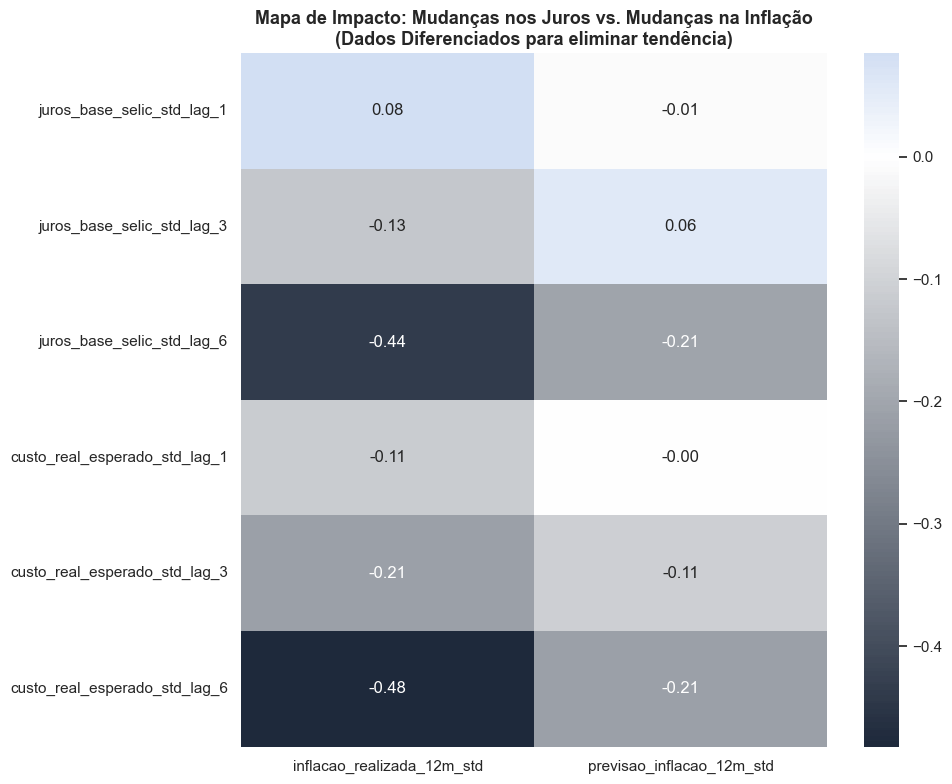

In [19]:
# 1. Criação dos Lags (Causas passadas)
drivers = ["juros_base_selic_std", "custo_real_esperado_std"]
for col in drivers:
    for lag in [1, 3, 6]:
        df_final[f"{col}_lag_{lag}"] = df_final[col].shift(lag)

# 2. Remoção da Tendência com .diff()
# Isso garante que estamos correlacionando MUDANÇAS e não apenas TENDÊNCIAS
df_estacionario = df_final.diff().dropna()


# 3. Gerando o Heatmap de Impacto Real
def plotar_heatmap_impacto(df_diff, paleta):
    # Definimos os alvos (o que queremos explicar hoje)
    # Quando os colegas trouxerem os dados da Olist, adicione 'vendas_std' aqui
    targets = ["inflacao_realizada_12m_std", "previsao_inflacao_12m_std"]

    # Filtramos as colunas de causa (lags)
    causas = [c for c in df_diff.columns if "_lag_" in c]

    # Calcula correlação apenas entre causas passadas e efeitos presentes
    matriz_corr = df_diff[causas + targets].corr().loc[causas, targets]

    plt.figure(figsize=(10, 8))
    cmap_custom = LinearSegmentedColormap.from_list(
        "olist", [paleta[2], "#ffffff", paleta[0]]
    )

    sns.heatmap(matriz_corr, annot=True, fmt=".2f", cmap=cmap_custom, center=0)

    plt.title(
        "Mapa de Impacto: Mudanças nos Juros vs. Mudanças na Inflação\n(Dados Diferenciados para eliminar tendência)",
        fontsize=13,
    )
    plt.tight_layout()
    plt.savefig('heatmap_impacto_macro.png')


plotar_heatmap_impacto(df_estacionario, PALETA_OLIST)

In [20]:
def plotar_cenario_macro_final(df_macro, paleta):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 7))

    # 1. Linha da Selic - Destaque Principal
    plt.plot(
        df_macro.index,
        df_macro["juros_base_selic"],
        label="Taxa Selic (Meta)",
        color=paleta[0],
        linewidth=4,
        zorder=5,
    )

    # 2. Inflação - Linha de apoio
    plt.plot(
        df_macro.index,
        df_macro["inflacao_realizada_12m"],
        label="IPCA (12 meses)",
        color=paleta[4],
        linestyle="--",
        alpha=0.8,
        zorder=3,
    )

    # 3. Juro Real - Área Sombreada
    # O Juro Real é a diferença que sobra após descontar a inflação
    plt.fill_between(
        df_macro.index,
        df_macro["custo_real_esperado"],
        color=paleta[1],
        alpha=0.2,
        label="Área de Juro Real",
    )

    plt.plot(
        df_macro.index,
        df_macro["custo_real_esperado"],
        color=paleta[2],
        linewidth=1.5,
        label="Tendência Juro Real",
        alpha=0.6,
    )

    # 4. Ajuste do Eixo Y para dar "ar" ao gráfico
    plt.ylim(0, 16)

    # 5. Anotação Corrigida
    # Apontando para o momento de queda em 2017
    plt.annotate(
        "Início do Ciclo de Queda (Selic)",
        xy=(pd.Timestamp("2017-01-01"), 13.0),
        xytext=(pd.Timestamp("2017-09-01"), 14.5),
        arrowprops=dict(
            arrowstyle="->", connectionstyle="arc3,rad=-0.2", color="black"
        ),
        fontsize=11,
        fontweight="bold",
    )

    # 6. Títulos e Estética
    plt.title(
        "Cenário Macroeconômico: Ciclo de Queda de Juros (2016-2018)",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )
    plt.ylabel("Taxa Anual (%)", fontsize=12)
    plt.xlabel("Ano/Mês", fontsize=12)
    plt.legend(frameon=True, facecolor="white", loc="upper right")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('cenario_macro_ciclo_queda.png')
    plt.show()

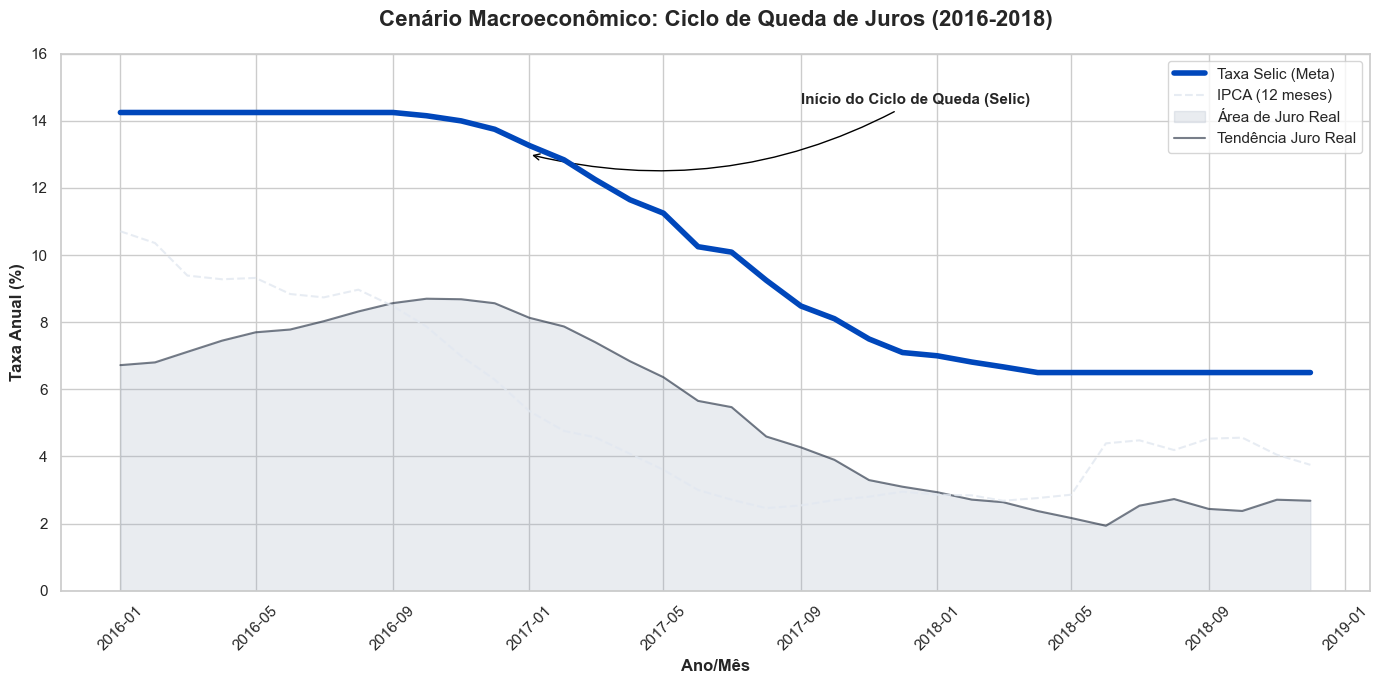

In [21]:
plotar_cenario_macro_final(df_final, PALETA_OLIST)